In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from src.sd_vae.ae import VAE
from src.sd_vae.discriminator import Discriminator
from src.trainers import EarlyStopping
from src.trainers.first_stage_trainer import VAEFirstStageTrainer

import src.utils.data_utils.styled_mnist.corruptions as corruptions
from src.utils.data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
mnist = MNIST("./data", train=True, download=False)

In [3]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:26<00:00, 2284.04item/s]


In [4]:
train_loader = DataLoader(train, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [ ]:
params = {
    "vae_lr": 5e-4,
    "disc_lr": 5e-4,
    "disc_warmup": 0,
    "optimizer": "Adam",
    "batch_size": 512,
    "beta": 1 / 8,
    "gamma": 100,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=8,
    norm_channels=32,
    n_heads=4,
).to(device)

disc = Discriminator(1, n_layers=3).to(device)

trainer = VAEFirstStageTrainer(
    model=vae,
    discriminator=disc,
    early_stopping=EarlyStopping(patience=10),
    verbose_period=2,
    device=device,
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["vae_lr"],
        "disc_lr": params["disc_lr"],
        "disc_warmup": params["disc_warmup"],
    },
)

In [12]:
# del vae
# del disc
torch.cuda.empty_cache()

In [ ]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test-vae")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=51, train_loader=train_loader, valid_loader=valid_loader)

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

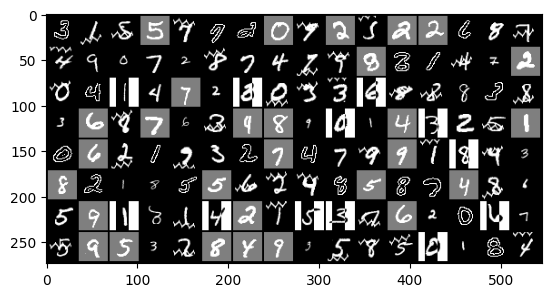

In [9]:
x = next(iter(test_loader))['image'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

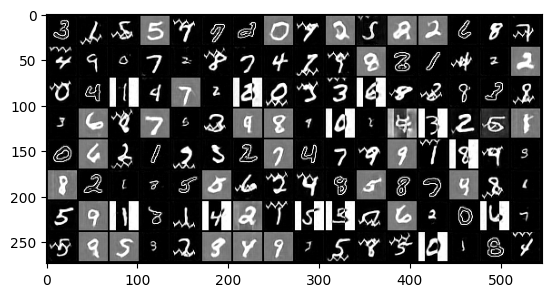

In [10]:
x = next(iter(test_loader))['image'].to("cuda")
best_model = mlflow.pytorch.load_model('runs:/112f028dd824498a81145aec209a719e/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

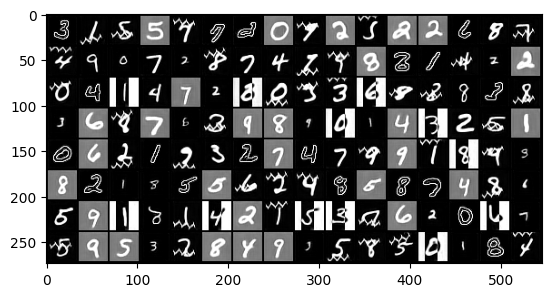

In [ ]:
z = posterior.mu.to(device)
with torch.no_grad():
    best_model.eval()
    z = z * 0.18215
    x = best_model.decoder(z)
    plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

torch.Size([128, 8, 8, 8])


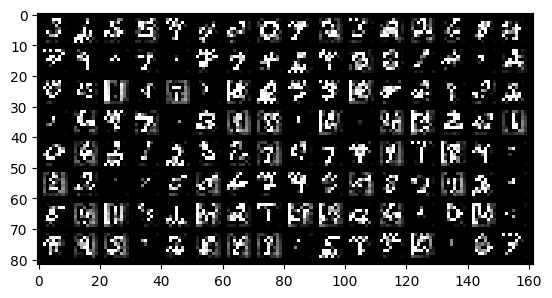

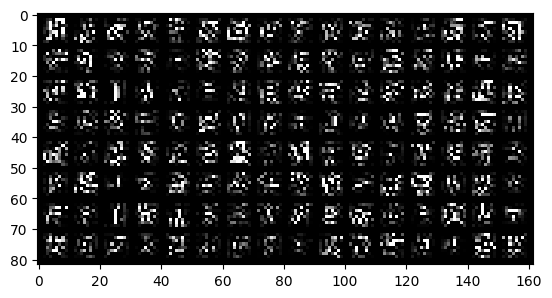

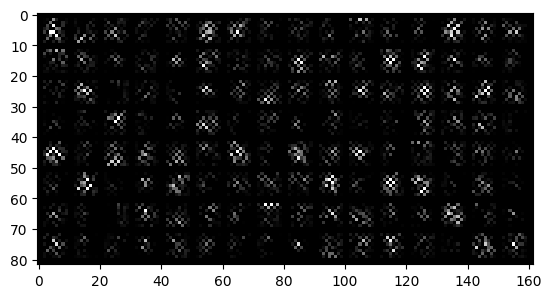

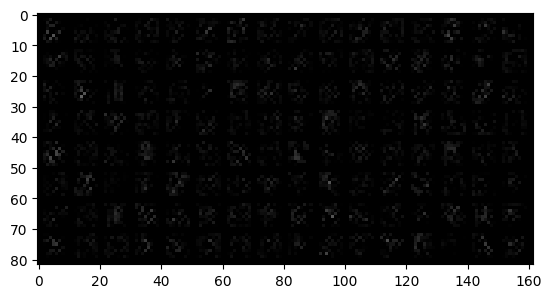

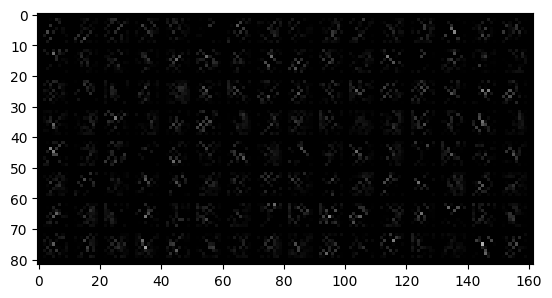

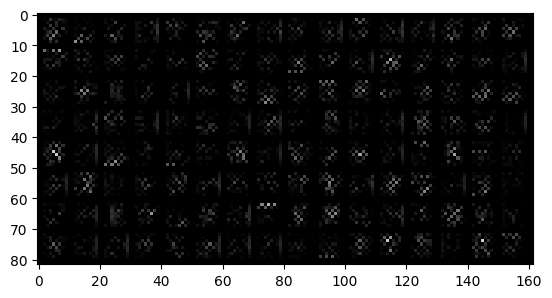

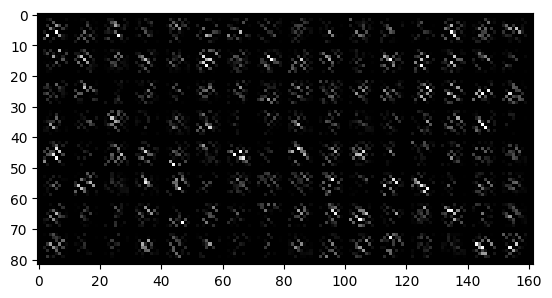

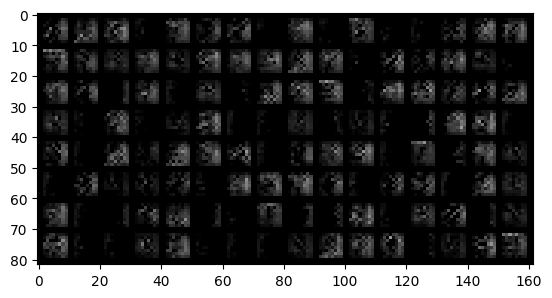

In [15]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()